In [500]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [501]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)

df = df.dropna(subset=['relative_quarterly_return'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14322 entries, 1 to 15338
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           14322 non-null  int64         
 1   datadate                        14322 non-null  datetime64[ns]
 2   tic                             14322 non-null  object        
 3   actq                            14322 non-null  float64       
 4   ancq                            14322 non-null  float64       
 5   epsfxq                          14302 non-null  float64       
 6   lctq                            14322 non-null  float64       
 7   ltq                             14322 non-null  float64       
 8   revtq                           14322 non-null  float64       
 9   capxy                           13783 non-null  float64       
 10  roa                             14289 non-null  float64       
 11  ro

In [502]:
drop_features = ['capxy', 'cfm', 'PEG_trailing', 'de_ratio', 'divyield']
df = df.drop(drop_features, 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 32 to 15337
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non-null  float64       
 11  p

In [503]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 80
['AAPL' 'ABT' 'ADBE' 'ADM' 'AMD' 'AMGN' 'AMT' 'AMZN' 'APD' 'BA' 'BAX'
 'BMY' 'CAT' 'CL' 'CME' 'COP' 'COST' 'CSCO' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL'
 'EQIX' 'EXC' 'EXPE' 'F' 'FDX' 'FIS' 'GE' 'GOOGL' 'HCA' 'HD' 'IBM' 'INTC'
 'JBL' 'JNJ' 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'META' 'MMC' 'MMM'
 'MRK' 'MSFT' 'MU' 'NFLX' 'NKE' 'NOC' 'NVDA' 'OXY' 'PFE' 'PG' 'PPL' 'PYPL'
 'QCOM' 'REGN' 'RJF' 'RTX' 'SBUX' 'SPGI' 'STZ' 'T' 'TGT' 'TMO' 'TSLA'
 'TSN' 'UNH' 'UPS' 'V' 'VZ' 'WBA' 'WDC' 'WMT' 'XOM' 'ZTS']


In [504]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.info()

Number of unique gvkeys: 80
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 172 to 3737
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non

In [505]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)].sort_values(by=['tic', 'datadate'])
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)].sort_values(by=['tic', 'datadate'])
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)].sort_values(by=['tic', 'datadate'])

train_df.head()

,gvkey,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,roa,...,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return,spindx,spindx_change,next_spindx_change,prccq,prccq_change,next_prccq_change
32,1690,1988-12-31,AAPL,0.079635,0.174100,0.309524,0.036776,0.050238,0.202288,0.422,...,0.109926,-0.144798,-0.090732,-0.176660,277.72,0.021367,0.061753,40.250,-0.069364,-0.114907
33,1690,1989-03-31,AAPL,-0.002265,0.140199,-0.600000,-0.069827,-0.015156,-0.112601,0.373,...,-0.025073,0.236976,-0.176660,0.079521,294.87,0.061753,0.078374,35.625,-0.114907,0.157895
34,1690,1989-06-30,AAPL,0.021059,0.097413,0.681818,-0.063730,-0.031102,0.001039,0.355,...,0.007287,-0.132255,0.079521,-0.019237,317.98,0.078374,0.098025,41.250,0.157895,0.078788
35,1690,1989-09-30,AAPL,0.169988,0.022918,0.675676,0.198772,0.163898,0.108583,0.315,...,0.090638,-0.105653,-0.019237,-0.220038,349.15,0.098025,0.012172,44.500,0.078788,-0.207865
36,1690,1989-12-31,AAPL,0.013564,0.085242,-0.225806,-0.002874,0.024924,0.079231,0.319,...,-0.004682,-0.266711,-0.220038,0.179931,353.40,0.012172,-0.038087,35.250,-0.207865,0.141844


In [506]:
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

drop_cols = ['gvkey', 'datadate', 'tic', 'spindx', 'spindx_change', 'next_spindx_change', 'prccq', 'prccq_change', 'next_prccq_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return
32,0.079635,0.174100,0.309524,0.036776,0.050238,0.202288,0.422,0.366,11.120,22.739,...,-0.016981,-0.084596,-0.025641,-0.030612,0.007246,-0.129302,0.109926,-0.144798,-0.090732,-0.176660
33,-0.002265,0.140199,-0.600000,-0.069827,-0.015156,-0.112601,0.373,0.320,15.453,38.382,...,-0.024952,0.017669,-0.114035,-0.136842,0.741007,0.028846,-0.025073,0.236976,-0.176660,0.079521
34,0.021059,0.097413,0.681818,-0.063730,-0.031102,0.001039,0.355,0.300,14.263,14.080,...,-0.003937,-0.057186,-0.009901,-0.036585,0.293388,-0.019730,0.007287,-0.132255,0.079521,-0.019237
35,0.169988,0.022918,0.675676,0.198772,0.163898,0.108583,0.315,0.293,12.535,11.013,...,0.015810,0.092809,0.100000,0.088608,-0.137380,-0.102754,0.090638,-0.105653,-0.019237,-0.220038
36,0.013564,0.085242,-0.225806,-0.002874,0.024924,0.079231,0.319,0.272,10.059,6.586,...,0.023346,-0.140966,-0.009091,-0.046512,-0.162963,0.011806,-0.004682,-0.266711,-0.220038,0.179931


In [507]:
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return',], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return',], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return',], 1)

X_train.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
32,0.079635,0.174100,0.309524,0.036776,0.050238,0.202288,0.422,0.366,11.120,22.739,...,-0.491803,-0.016981,-0.084596,-0.025641,-0.030612,0.007246,-0.129302,0.109926,-0.144798,-0.090732
33,-0.002265,0.140199,-0.600000,-0.069827,-0.015156,-0.112601,0.373,0.320,15.453,38.382,...,0.591398,-0.024952,0.017669,-0.114035,-0.136842,0.741007,0.028846,-0.025073,0.236976,-0.176660
34,0.021059,0.097413,0.681818,-0.063730,-0.031102,0.001039,0.355,0.300,14.263,14.080,...,0.108108,-0.003937,-0.057186,-0.009901,-0.036585,0.293388,-0.019730,0.007287,-0.132255,0.079521
35,0.169988,0.022918,0.675676,0.198772,0.163898,0.108583,0.315,0.293,12.535,11.013,...,-0.542683,0.015810,0.092809,0.100000,0.088608,-0.137380,-0.102754,0.090638,-0.105653,-0.019237
36,0.013564,0.085242,-0.225806,-0.002874,0.024924,0.079231,0.319,0.272,10.059,6.586,...,0.440000,0.023346,-0.140966,-0.009091,-0.046512,-0.162963,0.011806,-0.004682,-0.266711,-0.220038


In [508]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
0,0.171845,0.183717,0.602187,0.082556,0.108864,0.105216,0.872315,0.305406,0.555650,0.486555,...,0.303075,0.282728,0.504897,0.572128,0.892791,0.114723,0.064056,0.334475,0.023210,0.104713
1,0.158789,0.178411,0.598283,0.074064,0.102085,0.076260,0.857489,0.304848,0.557977,0.509869,...,0.308803,0.282708,0.505808,0.570778,0.892414,0.114974,0.078339,0.284476,0.034798,0.090544
2,0.162507,0.171715,0.603785,0.074549,0.100432,0.086709,0.852042,0.304605,0.557338,0.473650,...,0.306247,0.282760,0.505141,0.572368,0.892770,0.114821,0.073952,0.296461,0.023591,0.132785
3,0.186248,0.160056,0.603758,0.095460,0.120646,0.096599,0.839939,0.304520,0.556410,0.469080,...,0.302806,0.282809,0.506477,0.574046,0.893214,0.114674,0.066453,0.327331,0.024398,0.116501
4,0.161312,0.169810,0.599889,0.079397,0.106240,0.093900,0.841150,0.304265,0.555080,0.462482,...,0.308003,0.282828,0.504394,0.572380,0.892734,0.114665,0.076800,0.292028,0.019510,0.083392


In [509]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.1],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.




/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:58:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:58:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.25929094023083
CPU times: user 32.2 s, sys: 1.91 s, total: 34.1 s
Wall time: 15.1 s


In [510]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

CPU times: user 7.49 s, sys: 246 ms, total: 7.73 s
Wall time: 1.1 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

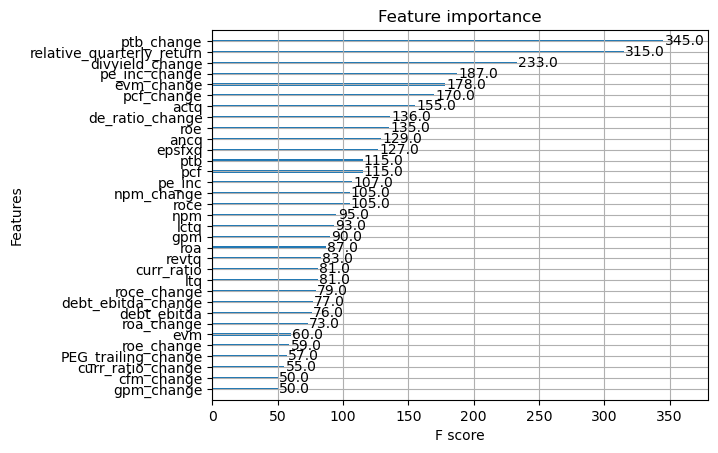

In [511]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [512]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(classification_report(y_test_binary, y_test_pred_binary))



              precision    recall  f1-score   support

           0       0.75      0.59      0.66      1470
           1       0.66      0.80      0.73      1465

    accuracy                           0.70      2935
   macro avg       0.71      0.70      0.69      2935
weighted avg       0.71      0.70      0.69      2935



In [513]:
results['y_pred'] = y_test_pred
#results = results.sort_values(by=['datadate', 'y_pred'])

results.head()



,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred
131,2013-09-30,AAPL,0.176759,0.077559,0.124467
132,2013-12-31,AAPL,-0.043278,-0.056252,0.001057
135,2014-09-30,AAPL,0.095583,0.051670,0.068938
136,2014-12-31,AAPL,0.127288,0.122921,0.049548
137,2015-03-31,AAPL,0.007996,0.010308,-0.024520


In [514]:
# Group by 'datadate' and calculate the count of rows and the mean of 'next_prccq_change'
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()


# Add a 'top_10' column that contains the average of the top 10 highest 'y_pred' for each quarter
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(10, 'y_pred')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(10, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'y_pred')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)

# Show the first few rows of the new dataframe
df_avg.head(10)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,66,0.091472,0.424071,0.435377,-0.021347,-0.084238
1,2013-06-30,67,0.072373,0.216697,0.316802,-0.015938,-0.061988
2,2013-09-30,70,0.106628,0.235707,0.318250,-0.060497,-0.081207
3,2013-12-31,69,0.036740,0.142012,0.212162,-0.017447,-0.089119
4,2014-03-31,69,0.043231,0.089474,0.168357,0.043606,-0.061300
5,2014-06-30,71,0.026139,0.095784,0.174932,-0.057136,-0.099601
6,2014-09-30,69,0.050479,0.173309,0.197413,-0.075149,-0.118342
7,2014-12-31,68,0.025900,0.121870,0.177872,-0.048405,-0.128522
8,2015-03-31,69,0.016074,0.141075,0.208564,-0.064951,-0.111613
9,2015-06-30,67,-0.055364,0.051937,0.097880,-0.182313,-0.221275


In [515]:
for portfolio in ['baseline', 'top_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.03605902462421427
Sharpe Ratio of the baseline portfolio: 0.17847995042685905

Mean quarterly return of the top_10 portfolio: 0.16767700195556537
Sharpe Ratio of the top_10 portfolio: 1.5124466747699288



In [516]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()


In [517]:
train_df = train_df[important_features + ['next_relative_quarterly_return']]
valid_df = valid_df[important_features + ['next_relative_quarterly_return']]
test_df  = test_df[important_features + ['next_relative_quarterly_return']]

y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return'], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return'], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return'], 1)

# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,ptb_change,relative_quarterly_return,divyield_change,pe_inc_change,evm_change
0,0.023210,0.104713,0.140545,0.549174,0.504897
1,0.034798,0.090544,0.101605,0.550532,0.505808
2,0.023591,0.132785,0.145492,0.549210,0.505141
3,0.024398,0.116501,0.150132,0.549085,0.506477
4,0.019510,0.083392,0.177245,0.548868,0.504394


In [518]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.05,
    'n_estimators': 300,
    'gamma': 0.1,
    'random_state': 42
}
eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(**params)
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [519]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_test_binary, y_test_pred_binary))


[ 0.07352004 -0.0291503   0.08640249 ...  0.05915682 -0.017184
  0.075367  ]
              precision    recall  f1-score   support

           0       0.73      0.61      0.67      1470
           1       0.67      0.77      0.71      1465

    accuracy                           0.69      2935
   macro avg       0.70      0.69      0.69      2935
weighted avg       0.70      0.69      0.69      2935



In [520]:
results['y_pred_sim'] = y_test_pred
results = results.sort_values(by=['datadate', 'y_pred_sim'])

results.tail(10)

,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred,y_pred_sim
13646,2023-06-30,TSLA,-0.044123,-0.007647,0.075187,0.087328
6347,2023-06-30,HD,0.110801,0.009768,0.045904,0.088934
14662,2023-06-30,WDC,0.203006,0.239481,0.149157,0.105067
8145,2023-06-30,LLY,0.145315,0.181791,0.147887,0.109029
2972,2023-06-30,CAT,0.109531,0.146006,0.172063,0.128446
3484,2023-06-30,COP,0.156259,0.192735,0.178149,0.146045
10718,2023-06-30,NVDA,0.683989,0.582956,0.202701,0.157848
6886,2023-06-30,JBL,0.278150,0.199719,0.186592,0.158307
532,2023-06-30,ADBE,0.338807,0.260375,0.177448,0.175658
9487,2023-06-30,MMM,-0.064642,-0.028166,0.332643,0.218603


In [525]:
# Group by 'datadate' and calculate the count of rows and the mean of 'next_prccq_change'
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()


# Add a 'top_10' column that contains the average of the top 10 highest 'y_pred' for each quarter
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(5, 'y_pred_sim')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(5, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'y_pred_sim')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)

# Show the first few rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,66,0.091472,0.660227,0.667934,-0.009733,-0.084238
1,2013-06-30,67,0.072373,0.285397,0.466270,-0.014270,-0.061988
2,2013-09-30,70,0.106628,0.224949,0.362922,-0.000798,-0.081207
3,2013-12-31,69,0.036740,0.128831,0.277631,-0.033762,-0.089119
4,2014-03-31,69,0.043231,0.086266,0.205114,0.029640,-0.061300
5,2014-06-30,71,0.026139,0.028926,0.210655,-0.043427,-0.099601
6,2014-09-30,69,0.050479,0.167644,0.227675,-0.055360,-0.118342
7,2014-12-31,68,0.025900,0.090864,0.202082,-0.075304,-0.128522
8,2015-03-31,69,0.016074,0.206250,0.296327,-0.075571,-0.111613
9,2015-06-30,67,-0.055364,0.079047,0.127415,-0.179315,-0.221275


In [522]:
for portfolio in ['baseline', 'top_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.03605902462421427
Sharpe Ratio of the baseline portfolio: 0.17847995042685905

Mean quarterly return of the top_10 portfolio: 0.16763608889267836
Sharpe Ratio of the top_10 portfolio: 1.5739905659122626

